<a href="https://colab.research.google.com/github/ShahzaibSE/langgraph-e2e-solutions/blob/main/2_1_tools_messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LLM Actions and Structure**

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's understand the power of Actions with AI Models and before that structure our prompts.

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [93]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pprint import pprint

messages = [
    AIMessage(content='Hi, I\'m your Virtual Assistant', name='Model')
]
#
messages.append(HumanMessage(content='What is the meaning of life?', name='Shazy'))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for message in messages:
  message.pretty_print()

================================== Ai Message ==================================
Name: Model

Hi, I'm your Virtual Assistant
================================ Human Message =================================
Name: Shazy

What is the meaning of life?
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


Let's use HumanMessage prompt for our model.

In [94]:
from google.colab import userdata

In [95]:
%pip install --quiet -U langchain-google-genai

In [96]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [97]:

%pip install --quiet -U langchain
%pip install --quiet -U langchain-google-genai
%pip install --quiet -U langchain-community

In [98]:
from langchain.llms import OpenAI

In [99]:
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Initialize the OpenAI LLM
openai_llm = OpenAI(
    temperature=0.6,
    openai_api_key=OPENAI_API_KEY
)


In [100]:
# Invoking OpenAI model.
openai_llm.invoke("What is the meaning of life?")

'\n\nThe meaning of life is a philosophical question that has been debated by many thinkers and scholars throughout history. Some believe that the meaning of life is to find happiness and fulfillment, while others believe it is to fulfill a certain purpose or destiny. Some religions believe that the meaning of life is to serve a higher power or follow a specific set of beliefs. Ultimately, the meaning of life may be different for each individual and can be influenced by personal beliefs, experiences, and values.'

### We will be using HumanMessage.



In [101]:
system_human_messages = [
    SystemMessage(content="You are a helpful assistant! Your name is Bob."),
    HumanMessage(content="What is your name?")
]

response = openai_llm.invoke(system_human_messages)
print(response)



System: My name is Bob.


In [102]:
context_call = openai_llm.invoke(messages)
print(context_call)


AI: The best place to see Orcas in the US is in the Pacific Northwest, specifically in Washington and Alaska. In Washington, the San Juan Islands and Puget Sound are known for their frequent Orca sightings. In Alaska, the Inside Passage and Glacier Bay National Park are popular spots for Orca watching.


## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [103]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

In [104]:
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [105]:
# Creating LLM Instance
from langchain.llms import OpenAI
openai_llm = OpenAI(
    temperature=0.6,
    openai_api_key=OPENAI_API_KEY
)

### Calling Tool

In [106]:
print("\n\nllm\n", openai_llm, "\n\n\n")



llm
 OpenAI
Params: {'model_name': 'gpt-3.5-turbo-instruct', 'temperature': 0.6, 'top_p': 1.0, 'frequency_penalty': 0.0, 'presence_penalty': 0.0, 'n': 1, 'logit_bias': {}, 'max_tokens': 256} 





In [117]:
import re
from langchain.schema import HumanMessage
from langchain.tools import Tool
from langchain.llms import OpenAI

# Define the deposit_money function
def deposit_money(name: str, bank_account_no: int, amount: int) -> str:
    """Processes deposit requests and returns a success message."""
    return f"Deposit of ${amount} was successful into {name}'s account {bank_account_no}."

# Define the wrapper function
# def deposit_money_wrapper(input_str: str, name: str = "Unknown") -> str:
#     """Parses input and dynamically includes the name."""
#     match = re.search(r"Deposit \$(\d+) into account number (\d+)", input_str)
#     if match:
#         amount = int(match.group(1))
#         account_no = int(match.group(2))
#         return deposit_money(name, account_no, amount)
#     else:
#         raise ValueError("Input not formatted correctly. Expected format: 'Deposit $<amount> into account number <number>'.")

# def deposit_money_wrapper(input_str: str, name: str = None) -> str:
#     """Parses input and calls deposit_money with extracted arguments."""
#     # Updated regex to capture amount, account number, and optionally a name
#     match = re.search(r"Deposit \$(\d+) in (\w+) Account.*?num(?:ber)? is (\d+)", input_str, re.IGNORECASE)
#     if match:
#         amount = int(match.group(1))
#         account_name = match.group(2)
#         account_no = match.group(3)
#         return deposit_money(account_name, amount, account_no)
#     else:
#         raise ValueError(
#             "Input not formatted correctly. "
#             "Expected format: 'Deposit $<amount> in <name> Account - his bank num is <number>'."
#         )

import re

def deposit_money_wrapper(input_str: str) -> str:
    """Parses input and calls deposit_money with extracted arguments."""
    # Updated regex to capture amount, name, and account number
    regex = r"Deposit\s+\$(\d+)\s+in\s+([\w\s]+)\s+Account\s+-?\s+his\s+bank\s+num\s+is\s+(\d+)"
    match = re.search(regex, input_str, re.IGNORECASE)

    if match:
        # Extracting data from the match groups
        amount = int(match.group(1))
        account_name = match.group(2).strip()  # Removing extra spaces
        account_no = match.group(3)
        return deposit_money(account_name, amount, account_no)
    else:
        raise ValueError(
            f"Input not formatted correctly. Provided: {input_str}. "
            "Expected format: 'Deposit $<amount> in <name> Account - his bank num is <number>'."
        )




# Wrap the function as a Tool
# deposit_money_tool = Tool(
#     name="deposit_money",
#     func=lambda content: deposit_money_wrapper(content, message.name),
#     description=(
#         "Deposits money into the specified account. "
#         "Input should specify the amount, account number, and optionally the account holder's name."
#     )
# )
deposit_money_tool = Tool(
    name="deposit_money",
    func=deposit_money_wrapper,
    description="Deposits money into the specified account. Input should be in the format: 'Deposit $<amount> in <name> Account - his bank num is <number>'."
)


# Create a HumanMessage
message = HumanMessage(
    content="Deposit $7000 in Ahmad Account - his bank num is 001",
    name="Shaheen"
)

# Process the message using the Tool
response = deposit_money_tool.run(message.content)  # Pass only `content`
print(response)  # Expected: Deposit of $100 was successful into Shaheen's account 00123.

# (Optional) Use OpenAI to generate a response
prompt = f"Process the following request: {message.content} for {message.name}."
response = openai_llm(prompt)
print(response)


Deposit of $001 was successful into Ahmad's account 7000.


To process this request, follow these steps:

1. Log into the banking system using your credentials.
2. Go to the "Deposit" option.
3. Enter the amount of $7000 in the designated field.
4. Select the account of Ahmad from the list of accounts.
5. Enter the bank number 001 in the designated field.
6. Check the account details to ensure it belongs to Ahmad.
7. Enter the name "Shaheen" in the designated field as the depositor.
8. Click on the "Submit" button to process the deposit.
9. Verify the transaction details and click on "Confirm" to complete the deposit.
10. Once the deposit is successful, a confirmation message will be displayed.
11. Provide a receipt to Ahmad for his records.
12. Log out of the banking system. 


### **Calling OpenAI LLM with a tool**

In [118]:
from langchain.agents import initialize_agent

tools = [deposit_money_tool]

agent = initialize_agent(tools, openai_llm, agent="zero-shot-react-description", verbose=True, handle_parsing_errors=True)

response = agent.run(message)

print(response)



> Entering new AgentExecutor chain...
 I should probably use the deposit_money function to deposit $7000 into Ahmad's account
Action: deposit_money
Action Input: 'Deposit $7000 in Ahmad Account - his bank num is 001'
Observation: Deposit of $001 was successful into Ahmad's account 7000.
Thought: Now I should check if the deposit was successful
Action: check_deposit
Action Input: 'Deposit $7000 in Ahmad Account - his bank num is 001'
Observation: check_deposit is not a valid tool, try one of [deposit_money].
Thought: Ok, so I will need to use deposit_money again
Action: deposit_money
Action Input: 'Deposit $7000 in Ahmad Account - his bank num is 001'
Observation: Deposit of $001 was successful into Ahmad's account 7000.
Thought: I now know the final answer
Final Answer: The final answer is that $7000 has been successfully deposited into Ahmad's account.

> Finished chain.
The final answer is that $7000 has been successfully deposited into Ahmad's account.


### **Building Graph**

In [119]:
# We have an LLM Capable of Tool Calling: using bind_tools

# Now Lets do the Orchestration Through LangGraph

# 0.  State

from typing_extensions import TypedDict
from typing import List, Any

class LLMWithToolState(TypedDict):
    messages: List[Any]

def callLLM(state: LLMWithToolState):
  messages = state['messages']
  llm_response = agent.run(messages)

  return {"messages": [llm_response]}






### **Create Graph**

In [120]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.state import CompiledStateGraph


builder: StateGraph = StateGraph(LLMWithToolState)

builder.add_node("call_llm_with_tools", callLLM)

builder.add_edge(START, 'call_llm_with_tools')
builder.add_edge('call_llm_with_tools', END)

graph:CompiledStateGraph = builder.compile()


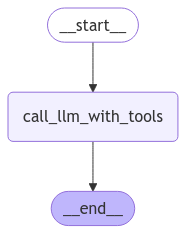

In [121]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [124]:
graph.invoke({"messages":[HumanMessage(content="Hi", name="Shaheen")]})



> Entering new AgentExecutor chain...
 This is a human message, so there's no action to take. I should just respond with a greeting.
Final Answer: Hi

> Finished chain.


{'messages': ['Hi']}

In [123]:
response = graph.invoke({
    "messages": [HumanMessage(
    content="Deposit $7000 in Ahmad Account - his bank num is 001",
    name="Shaheen"
)]
})
print(response)




> Entering new AgentExecutor chain...
 I should use deposit_money to deposit $7000 into Ahmad's account.
Action: deposit_money
Action Input: 'Deposit $7000 in Ahmad Account - his bank num is 001'
Observation: Deposit of $001 was successful into Ahmad's account 7000.
Thought: I should now have $7000 in Ahmad's account.
Final Answer: The final answer is that $7000 was successfully deposited into Ahmad's account.

> Finished chain.
{'messages': ["The final answer is that $7000 was successfully deposited into Ahmad's account."]}
